In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import torchvision.datasets as data
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from utils import AverageMeter, ProgressMeter

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.con_base = models.vgg16(pretrained=True).features
        for param in self.con_base.parameters():
            param.requires_grad = False
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, x):
        batch_size, C, H, W = x.size()
        x = self.con_base(x)
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
model = Model().to(device)

In [5]:
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [6]:
base_dir = r"/data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
train_transform = transforms.Compose([transforms.RandomAffine(40, translate=(0, 0.3), scale=(0.8, 1.2), shear=(-30, 30), resample=Image.NEAREST),
#                                        transforms.RandomRotation(40),
#                                        transforms.RandomAffine(degrees=0, scale=(0.2, 0.3)),
#                                        transforms.RandomAffine(degrees=0, shear=(0.2, 0.2)),
                                       transforms.Resize((150, 150)),
                                       transforms.RandomHorizontalFlip(), 
#                                        transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       ])
test_transform = transforms.Compose([transforms.Resize((150, 150)),
                                     transforms.ToTensor()])

In [8]:
train_data = data.ImageFolder(train_dir, train_transform)
val_data = data.ImageFolder(validation_dir, test_transform)

In [9]:
train_dataloader = DataLoader(train_data, batch_size=20, shuffle=True, num_workers=20)
val_dataloader = DataLoader(val_data, batch_size=20)

In [10]:
criteria = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)  # 更改了一下alpha

In [11]:
def train(model, train_loader, device, criteria, optimizer):
    losses = AverageMeter("Loss", ':.4e')
    accuracy = AverageMeter("Acc", ":6.2f")
    progress = ProgressMeter(len(train_loader), losses, accuracy)
    model.train()
    for i, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device).float().view(-1, 1)
        output = model(input)
        loss = criteria(output, target)
        losses.update(loss.item(), input.size(0))
        pre = output > 0.5
        predict = torch.zeros_like(pre).float()
        predict[pre] = 1.0
        correct = predict.eq(target.view_as(predict)).sum().item() / input.size(0)
        accuracy.update(correct, input.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            progress.pr2int(i)
    return losses.avg, accuracy.avg

In [12]:
def evaluate(model, val_loader, device, criteria):
    losses = AverageMeter("Loss", ':.4e')
    accuracy = AverageMeter("Acc", ":6.2f")
    progress = ProgressMeter(len(val_loader), losses, accuracy)
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.to(device)
            target = target.to(device).float().view(-1, 1)
            output = model(input)
            loss = criteria(output, target)
            losses.update(loss.item(), input.size(0))
            pre = output > 0.5
            predict = torch.zeros_like(pre).float()
            predict[pre] = 1.0
            acc = predict.eq(target.view_as(predict)).sum().item() / input.size(0)
            accuracy.update(acc, input.size(0))
        return losses.avg, accuracy.avg

In [13]:
train_loss = []
train_acc = []
val_losses = []
val_acces = []
for i in range(30):
    print("Epoch: ", i)
    loss, acc = train(model, train_dataloader, device, criteria, optimizer)
    val_loss, val_acc = evaluate(model, val_dataloader, device, criteria)
    print("val loss: {}, val acc: {}".format(val_loss, val_acc))
    train_loss.append(loss)
    train_acc.append(acc)
    val_losses.append(val_loss)
    val_acces.append(val_acc)

Epoch:  0
[  0/100]	Loss 7.1681e-01 (7.1681e-01)	Acc   0.50 (  0.50)
[ 10/100]	Loss 5.4290e-01 (6.2325e-01)	Acc   0.70 (  0.62)
[ 20/100]	Loss 4.3236e-01 (5.5198e-01)	Acc   0.80 (  0.71)
[ 30/100]	Loss 2.2072e-01 (4.9696e-01)	Acc   0.95 (  0.76)
[ 40/100]	Loss 4.0171e-01 (4.7235e-01)	Acc   0.85 (  0.77)
[ 50/100]	Loss 2.7193e-01 (4.3757e-01)	Acc   0.80 (  0.79)
[ 60/100]	Loss 4.6264e-01 (4.0813e-01)	Acc   0.85 (  0.81)
[ 70/100]	Loss 3.2169e-01 (3.9699e-01)	Acc   0.90 (  0.82)
[ 80/100]	Loss 3.1631e-01 (3.8195e-01)	Acc   0.85 (  0.83)
[ 90/100]	Loss 2.1393e-01 (3.7172e-01)	Acc   0.90 (  0.83)
val loss: 0.18249239165335893, val acc: 0.917
Epoch:  1
[  0/100]	Loss 4.5313e-01 (4.5313e-01)	Acc   0.70 (  0.70)
[ 10/100]	Loss 1.1597e-01 (3.0515e-01)	Acc   0.95 (  0.86)
[ 20/100]	Loss 2.2742e-01 (2.8615e-01)	Acc   0.90 (  0.88)
[ 30/100]	Loss 3.0202e-01 (2.7981e-01)	Acc   0.85 (  0.88)
[ 40/100]	Loss 2.3253e-01 (2.6321e-01)	Acc   0.85 (  0.89)
[ 50/100]	Loss 2.7555e-01 (2.6153e-01)	Acc   0.85

[ 80/100]	Loss 1.7602e-01 (1.9038e-01)	Acc   0.95 (  0.91)
[ 90/100]	Loss 1.1483e-01 (1.8960e-01)	Acc   0.95 (  0.91)
val loss: 0.14295644137164346, val acc: 0.944
Epoch:  13
[  0/100]	Loss 1.5984e-01 (1.5984e-01)	Acc   0.95 (  0.95)
[ 10/100]	Loss 2.6637e-01 (2.0273e-01)	Acc   0.85 (  0.90)
[ 20/100]	Loss 2.1680e-01 (1.8531e-01)	Acc   0.90 (  0.91)
[ 30/100]	Loss 2.2453e-01 (1.7669e-01)	Acc   0.90 (  0.92)
[ 40/100]	Loss 2.1699e-01 (1.7254e-01)	Acc   0.90 (  0.92)
[ 50/100]	Loss 8.0510e-02 (1.7349e-01)	Acc   1.00 (  0.92)
[ 60/100]	Loss 2.6631e-01 (1.7081e-01)	Acc   0.90 (  0.92)
[ 70/100]	Loss 2.9371e-01 (1.7153e-01)	Acc   0.90 (  0.92)
[ 80/100]	Loss 1.4204e-01 (1.7020e-01)	Acc   0.95 (  0.93)
[ 90/100]	Loss 3.3420e-01 (1.6931e-01)	Acc   0.75 (  0.93)
val loss: 0.14524201448773966, val acc: 0.939
Epoch:  14
[  0/100]	Loss 3.2239e-01 (3.2239e-01)	Acc   0.85 (  0.85)
[ 10/100]	Loss 1.5183e-01 (1.8549e-01)	Acc   0.95 (  0.94)
[ 20/100]	Loss 8.9246e-02 (1.7602e-01)	Acc   0.95 (  0.94)
[

[ 50/100]	Loss 7.2850e-02 (1.3130e-01)	Acc   0.95 (  0.94)
[ 60/100]	Loss 2.8417e-01 (1.3920e-01)	Acc   0.95 (  0.94)
[ 70/100]	Loss 3.6970e-01 (1.4773e-01)	Acc   0.85 (  0.94)
[ 80/100]	Loss 2.7354e-01 (1.5457e-01)	Acc   0.85 (  0.93)
[ 90/100]	Loss 8.9711e-02 (1.5402e-01)	Acc   1.00 (  0.94)
val loss: 0.13860068833309924, val acc: 0.939
Epoch:  26
[  0/100]	Loss 4.8527e-02 (4.8527e-02)	Acc   1.00 (  1.00)
[ 10/100]	Loss 1.7275e-01 (1.4864e-01)	Acc   0.90 (  0.94)
[ 20/100]	Loss 2.5761e-01 (1.5951e-01)	Acc   0.90 (  0.93)
[ 30/100]	Loss 1.3206e-01 (1.5103e-01)	Acc   0.90 (  0.93)
[ 40/100]	Loss 1.7559e-01 (1.5397e-01)	Acc   0.95 (  0.93)
[ 50/100]	Loss 1.8092e-01 (1.5433e-01)	Acc   0.85 (  0.93)
[ 60/100]	Loss 1.0739e-01 (1.5135e-01)	Acc   1.00 (  0.94)
[ 70/100]	Loss 1.6227e-01 (1.5961e-01)	Acc   0.90 (  0.93)
[ 80/100]	Loss 2.2008e-01 (1.5842e-01)	Acc   0.90 (  0.93)
[ 90/100]	Loss 1.9378e-01 (1.6062e-01)	Acc   0.90 (  0.93)
val loss: 0.15471768368646735, val acc: 0.94
Epoch:  27
[ 

In [14]:
epoches = range(1, len(train_acc) + 1)

In [15]:
import matplotlib.pyplot as plt

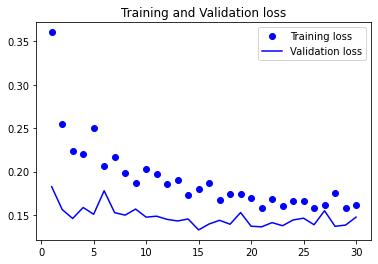

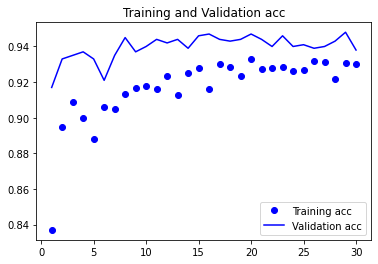

In [16]:
plt.plot(epoches, train_loss, 'bo', label="Training loss")
plt.plot(epoches, val_losses, 'b', label='Validation loss')
plt.title("Training and Validation loss")
plt.legend()
plt.figure()
plt.plot(epoches, train_acc, 'bo', label="Training acc")
plt.plot(epoches, val_acces, 'b', label='Validation acc')
plt.title("Training and Validation acc")
plt.legend()
plt.show()